In [10]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from collections import defaultdict


In [11]:
class BlackjackAgent:
    def __init__(self, env,
        learning_rate,
        initial_epsilon,
        epsilon_decay,
        final_epsilon,
        discount_factor = 0.95):

        self.env = env
        self.learning_rate = learning_rate
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.discount_factor = discount_factor

        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
        
        self.trainingError = []

    def getAction(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # Explore action space
        else:
            return np.argmax(self.q_table[state])  # Exploit learned values
    
    def updateQVal(self, state, action, reward, terminated, nextState):
        futureQ = (not terminated) * np.max(self.q_table[nextState])

        target = reward + self.discount_factor * futureQ

        temporalDifference = target - self.q_table[state][action]

        self.q_table[state][action] += self.learning_rate * temporalDifference

        self.trainingError.append(abs(temporalDifference))

    def decayEpsilon(self):
        self.epilson = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


In [12]:

learning_rate = 0.01        # How fast to learn (higher = faster but less stable)
n_episodes = 100_000        # Number of hands to practice
start_epsilon = 1.0         # Start with 100% random actions
epsilon_decay = start_epsilon / (n_episodes / 2)  # Reduce exploration over time
final_epsilon = 0.1         # Always keep some exploration
env = gym.make('Blackjack-v1', natural=False, sab=False)

In [13]:
agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [18]:
episode_rewards = []
episode_lengths = []
for episode in tqdm(range(n_episodes)):
    state, info = env.reset()
    terminated = False
    episode_reward = 0
    episode_length = 0

    while not terminated:
        action = agent.getAction(state)
        nextState, reward, terminated, truncated, info = env.step(action)
        agent.updateQVal(state, action, reward, terminated, nextState)
        state = nextState
        episode_reward += reward
        episode_length += 1

    agent.decayEpsilon()
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)

100%|██████████| 100000/100000 [00:15<00:00, 6462.47it/s]


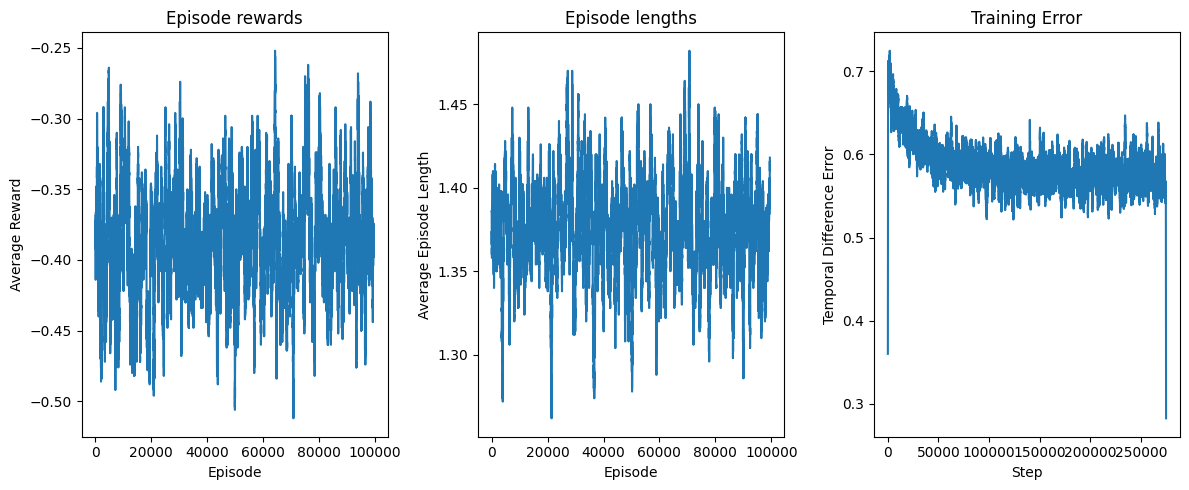

In [19]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    episode_rewards,
    rolling_length,
    "valid"
    )
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    episode_lengths,
    rolling_length,
    "valid"
    )
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.trainingError,
    rolling_length,
    "same"
    )
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
plt.show()

In [20]:
def testAgent(agent, env, n_episodes=1000):
    totalRewards = []
    oldEpsilon = agent.epsilon
    agent.epsilon = 0.0  # No exploration during testing

    for _ in tqdm(range(n_episodes)):
        state, info = env.reset()
        terminated = False
        episode_reward = 0

        while not terminated:
            action = agent.getAction(state)
            nextState, reward, terminated, truncated, info = env.step(action)
            state = nextState
            episode_reward += reward

        totalRewards.append(episode_reward)

    agent.epsilon = oldEpsilon  # Restore original epsilon
    win_rate = np.mean(np.array(totalRewards) > 0)
    average_reward = np.mean(totalRewards)

    print(f"Test Results over {n_episodes} episodes:")
    print(f"Win Rate: {win_rate:.1%}")
    print(f"Average Reward: {average_reward:.3f}")
    print(f"Standard Deviation: {np.std(totalRewards):.3f}")


In [21]:
testAgent(agent, env)

100%|██████████| 1000/1000 [00:00<00:00, 5491.41it/s]

Test Results over 1000 episodes:
Win Rate: 45.4%
Average Reward: 0.005
Standard Deviation: 0.950
